# Timeit comparison between pip-like coding vs std line coding  
This compares a pipe-like concatenation of pandas dataframe functoins with a standard
line-by-line approach of pandas coding

Seems that standrd coding is slightly faster, like 

In [2]:
import pandas as pd  
import datetime     
from enum import Enum    
import time
import matplotlib.pyplot as plt

# Utils

In [6]:
class ColumnType(Enum):
    DATETIME = 'datetime64[ns]'
    TIMESTAMP = 'datetime64[us]'
    STRING = 'str'
    INTEGER = 'Int64'
    FLOAT = 'float64'
    BOOLEAN = 'bool'

def time_function(func, repetitions):
    total_time = 0
    for _ in range(repetitions):
        start_time = time.time()
        func()
        end_time = time.time()
        
        execution_time = (end_time - start_time) * 1000
        total_time += execution_time
    
    return total_time

def plot_execution_times(f1_times, f2_times):
    plt.plot(f1_times, label='Function 1')
    plt.plot(f2_times, label='Function 2')

    plt.xlabel('Repetition')
    plt.ylabel('Execution Time (ms)')
    plt.title('Function Execution Times')
    plt.legend()
    plt.show()

def compare_execution_time(f1_avg_time, f2_avg_time):
    time_diff = f1_avg_time - f2_avg_time
    print(f"Difference in execution time f1-f2: {time_diff} ms")

def relative_speedup(f1_avg_time, f2_avg_time):
    if f2_avg_time == 0:
        return "Cannot calculate relative speedup. Division by zero."
    
    speedup = f1_avg_time / f2_avg_time
    print(f"Relative speedup f1/f2: {speedup:.2f}x")

def performance_improvement(f1_avg_time, f2_avg_time):
    improvement = ((f2_avg_time - f1_avg_time) / f2_avg_time) * 100
    print(f"Performance improvement (f1-f2 / f1): {improvement:.2f}%")

def compare_execution_times(f1_times, f2_times):
    f1_avg_time = sum(f1_times) / len(f1_times)
    f2_avg_time = sum(f2_times) / len(f2_times)
    
    compare_execution_time(f1_avg_time, f2_avg_time)
    relative_speedup(f1_avg_time, f2_avg_time)
    performance_improvement(f1_avg_time, f2_avg_time)

# Functions

In [10]:
def clean_df(df: pd.DataFrame) -> pd.DataFrame:
    column_types = {
        'ocean_proximity'     : ColumnType.STRING.value,
        'total_bedrooms'      : ColumnType.INTEGER.value,
        'total_rooms'         : ColumnType.INTEGER.value,
        'start'               : ColumnType.DATETIME.value,
        'end'                 : ColumnType.DATETIME.value,
    }

    cleaned = (
        df
        .query("ocean_proximity == 'INLAND' and total_rooms > 1000")
        .assign(
            start = lambda df: df.start.clip(upper = '2140-01-01 00:00:00'),
            end = lambda df: df.end.clip(upper = '2140-01-01 00:00:00'),
        )
        .astype(column_types)
        .reset_index(drop=True)
    )
    return cleaned

# Function 1; piped mode
def f1():
    df = (
            pd.read_csv(filepath_or_buffer="../data/housing.csv")
            .assign(
                start = datetime.datetime.now(),
                end = datetime.datetime.now()
            ).pipe(clean_df)
    )

# Function 2; non-piped mode
def f2():
    # semi-piped mode
    df = pd.read_csv(filepath_or_buffer="../data/housing.csv")
    df['start'] = datetime.datetime.now()
    df['end'] = datetime.datetime.now()
    df = df[(df['ocean_proximity']=='INLAND') & (df['total_rooms']>1000)]
    df['start'] = df['start'].clip(upper = '2140-01-01 00:00:00')
    df['start'] = df['start'].clip(upper = '2140-01-01 00:00:00')
    column_types = {
        'ocean_proximity'               : ColumnType.STRING.value,
        'total_bedrooms'                : ColumnType.INTEGER.value,
        'total_rooms'                   : ColumnType.INTEGER.value,
        'start'                         : ColumnType.DATETIME.value,
        'end'                           : ColumnType.DATETIME.value,
    }
    df = df.astype(column_types).reset_index()

# Compare executions


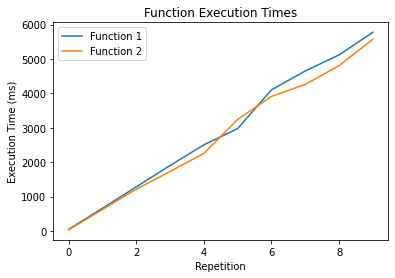

Difference in execution time f1-f2: 136.67974472045898 ms
Relative speedup f1/f2: 1.05x
Performance improvement (f1-f2 / f1): -4.94%


In [12]:
print(f"Function 1 is piped")
print(f"Function 2 is std")

# plot exec times
times = []
for reps in range(1, 200, 20):
    t1 = time_function(f1, reps)
    t2 = time_function(f2, reps)
    times.append( (t1,t2) )


plot_execution_times([t[0] for t in times], [t[1] for t in times])


# Compare execution times, faster is better
compare_execution_times(
    [t[0] for t in times],
    [t[1] for t in times]
    )